In [1]:
!pip install numpy scipy pillow requests tqdm

In [2]:
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...


In [2]:
import os
import subprocess

In [4]:
pip install keras tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

original_data_dir = 'dataset'
synthetic_data_dir = 'synthetic_images/'

def generate_synthetic_images(original_dir, synthetic_dir, num_augmented_images=20):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    for cloud_class in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, cloud_class)
        synthetic_class_dir = os.path.join(synthetic_dir, cloud_class)
        if not os.path.exists(synthetic_class_dir):
            os.makedirs(synthetic_class_dir)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isdir(img_path) or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img = load_img(img_path)
            x = img_to_array(img) 
            x = x.reshape((1,) + x.shape)  
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=synthetic_class_dir, save_prefix='synthetic', save_format='jpeg'):
                i += 1
                if i >= num_augmented_images:  
                    break

        print(f"Synthetic images created for class: {cloud_class}")

generate_synthetic_images(original_data_dir, synthetic_data_dir, num_augmented_images=20)

Synthetic images created for class: Ac
Synthetic images created for class: As
Synthetic images created for class: Cb
Synthetic images created for class: Cc
Synthetic images created for class: Ci
Synthetic images created for class: Cs
Synthetic images created for class: Ct
Synthetic images created for class: Cu
Synthetic images created for class: Ns
Synthetic images created for class: Sc
Synthetic images created for class: St


In [7]:
for cloud_class in os.listdir(synthetic_data_dir):
    synthetic_class_dir = os.path.join(synthetic_data_dir, cloud_class)
    synthetic_images = os.listdir(synthetic_class_dir)
    print(f"Synthetic images in '{cloud_class}': {len(synthetic_images)}")

Synthetic images in 'Ac': 3206
Synthetic images in 'As': 3133
Synthetic images in 'Cb': 3817
Synthetic images in 'Cc': 4125
Synthetic images in 'Ci': 2420
Synthetic images in 'Cs': 4356
Synthetic images in 'Ct': 3313
Synthetic images in 'Cu': 3060
Synthetic images in 'Ns': 4216
Synthetic images in 'Sc': 4973
Synthetic images in 'St': 3323


In [4]:
original_data_dir = 'dataset'  
synthetic_data_dir = 'synthetic_images/'  

def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

def count_files_by_class(data_dir):
    file_counts = {}
    for cloud_class in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, cloud_class)
        if os.path.isdir(class_dir):
            file_counts[cloud_class] = len(os.listdir(class_dir))
    return file_counts

original_file_count = count_files_in_directory(original_data_dir)
synthetic_file_count = count_files_in_directory(synthetic_data_dir)

print(f"Total original images: {original_file_count}")
print(f"Total synthetic images: {synthetic_file_count}")

original_class_counts = count_files_by_class(original_data_dir)
synthetic_class_counts = count_files_by_class(synthetic_data_dir)

print("\nOriginal images by class:")
for cloud_class, count in original_class_counts.items():
    print(f"{cloud_class}: {count} images")

print("\nSynthetic images by class:")
for cloud_class, count in synthetic_class_counts.items():
    print(f"{cloud_class}: {count} images")

Total original images: 2583
Total synthetic images: 39942

Original images by class:
Ac: 194 images
As: 189 images
Cb: 242 images
Cc: 269 images
Ci: 139 images
Cs: 288 images
Ct: 201 images
Cu: 183 images
Ns: 275 images
Sc: 341 images
St: 203 images

Synthetic images by class:
Ac: 3206 images
As: 3133 images
Cb: 3817 images
Cc: 4125 images
Ci: 2420 images
Cs: 4356 images
Ct: 3313 images
Cu: 3060 images
Ns: 4216 images
Sc: 4973 images
St: 3323 images


In [7]:
import shutil
original_data_dir = 'dataset'      
synthetic_data_dir = 'synthetic_images/' 
combined_dataset_dir = 'combined_dataset/' 

image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

def merge_datasets(source_dir, target_dir, prefix=None):
    for cloud_class in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, cloud_class)
        if cloud_class == '.ipynb_checkpoints' or not os.path.isdir(class_dir):
            continue
        target_class_dir = os.path.join(target_dir, cloud_class)
        if not os.path.exists(target_class_dir):
            os.makedirs(target_class_dir)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if not img_name.lower().endswith(image_extensions):
                continue
            new_img_name = img_name if prefix is None else f"{prefix}_{img_name}"
            target_img_path = os.path.join(target_class_dir, new_img_name)            
            shutil.copy(img_path, target_img_path)

merge_datasets(original_data_dir, combined_dataset_dir)

merge_datasets(synthetic_data_dir, combined_dataset_dir, prefix="synthetic")

print("Original and synthetic datasets have been combined into 'combined_dataset/'.")


Original and synthetic datasets have been combined into 'combined_dataset/'.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
dataset_dir = 'combined_dataset' 

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    dataset_dir,  
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 33971 images belonging to 11 classes.
Found 8486 images belonging to 11 classes.
Found 42457 images belonging to 11 classes.


In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 436s 401ms/step - accuracy: 0.2863 - loss: 2.1341 - val_accuracy: 0.3838 - val_loss: 1.7670 - learning_rate: 0.0010
Epoch 2/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 433s 407ms/step - accuracy: 0.3763 - loss: 1.8024 - val_accuracy: 0.4218 - val_loss: 1.6638 - learning_rate: 0.0010
Epoch 3/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 490s 460ms/step - accuracy: 0.3838 - loss: 1.7633 - val_accuracy: 0.4279 - val_loss: 1.6355 - learning_rate: 0.0010
Epoch 4/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 519s 487ms/step - accuracy: 0.4025 - loss: 1.7208 - val_accuracy: 0.4513 - val_loss: 1.5715 - learning_rate: 0.0010
Epoch 5/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 495s 464ms/step - accuracy: 0.4113 - loss: 1.6872 - val_accuracy: 0.4454 - val_loss: 1.5859 - learning_rate: 0.0010
Epoch 6/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 475s 447ms/step - accuracy: 0.4140 - loss: 1.6735 - val_accuracy: 0.4588 - val_loss: 1.5332 - learning_rate: 0.0010
Epoch 7/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 471s 442ms

In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

1327/1327 ━━━━━━━━━━━━━━━━━━━━ 280s 211ms/step - accuracy: 0.5871 - loss: 1.2008
Test accuracy: 0.5847092270851135


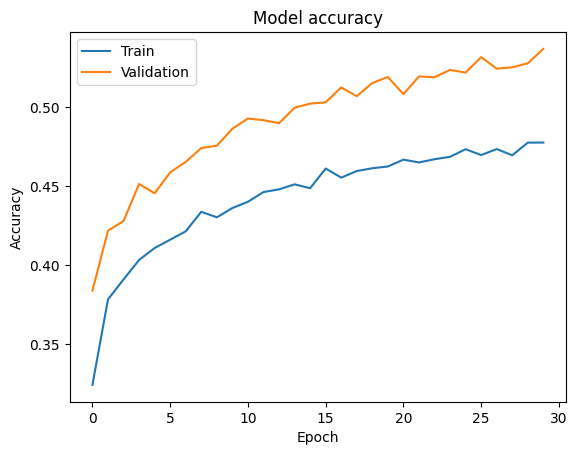

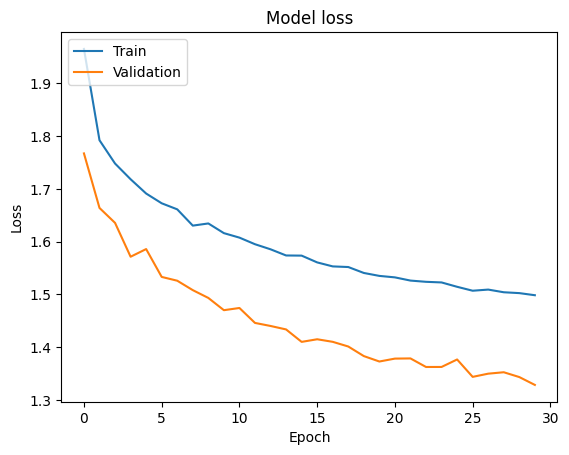

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import regularizers

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers[:-50]: 
    layer.trainable = False

In [6]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.6),  # Increase dropout to reduce overfitting
    Dense(train_generator.num_classes, activation='softmax')
])

In [7]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr = 1e-4
    if epoch > 20:
        lr = 1e-5
    return lr

model.compile(optimizer=tf.keras.optimizers.Adam(clipnorm=1.0), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(
    train_generator,
    epochs=50,  # Increased epochs
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/50


C:\Users\lavanyaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 556s 511ms/step - accuracy: 0.3498 - loss: 2.6523 - val_accuracy: 0.4966 - val_loss: 1.6179 - learning_rate: 0.0010
Epoch 2/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 540s 507ms/step - accuracy: 0.5244 - loss: 1.5709 - val_accuracy: 0.5847 - val_loss: 1.3750 - learning_rate: 0.0010
Epoch 3/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 534s 502ms/step - accuracy: 0.5835 - loss: 1.3478 - val_accuracy: 0.6224 - val_loss: 1.2229 - learning_rate: 0.0010
Epoch 4/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 562s 502ms/step - accuracy: 0.6418 - loss: 1.1796 - val_accuracy: 0.6221 - val_loss: 1.2040 - learning_rate: 0.0010
Epoch 5/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 531s 499ms/step - accuracy: 0.6672 - loss: 1.0905 - val_accuracy: 0.6876 - val_loss: 1.0088 - learning_rate: 0.0010
Epoch 6/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 545s 512ms/step - accuracy: 0.7008 - loss: 0.9991 - val_accuracy: 0.7032 - val_loss: 0.9651 - learning_rate: 0.0010
Epoch 7/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 529s 497ms/step - acc

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

1327/1327 ━━━━━━━━━━━━━━━━━━━━ 498s 375ms/step - accuracy: 0.9359 - loss: 0.1920
Test accuracy: 0.9331794381141663


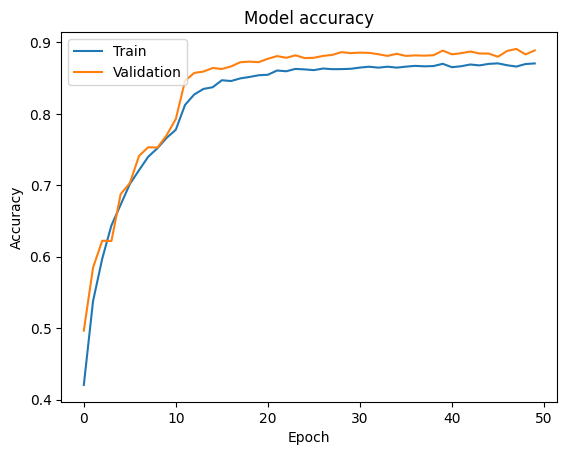

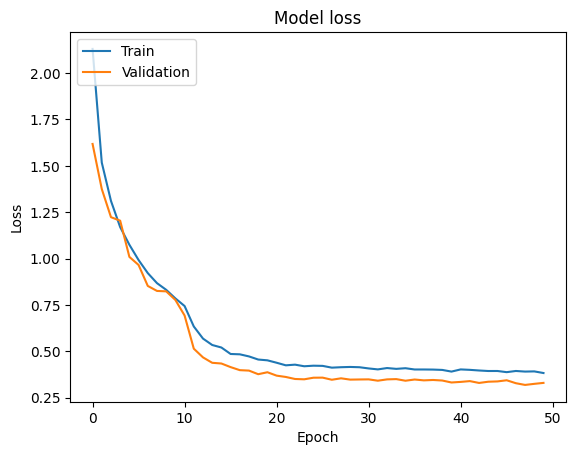

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted cloud class label: Stratus
Cloud prediction probabilities: {'Altocumulus': 1.4214363e-05, 'Altostratus': 8.6233086e-07, 'Cumulonimbus': 4.1728254e-06, 'Cirrocumulus': 0.00020882633, 'Cirrus': 5.3134595e-06, 'Cirrostratus': 0.000254591, 'Contrails': 1.3557852e-05, 'Cumulus': 6.914745e-07, 'Nimbostratus': 6.1542494e-05, 'Stratocumulus': 0.037708968, 'Stratus': 0.9617273}


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

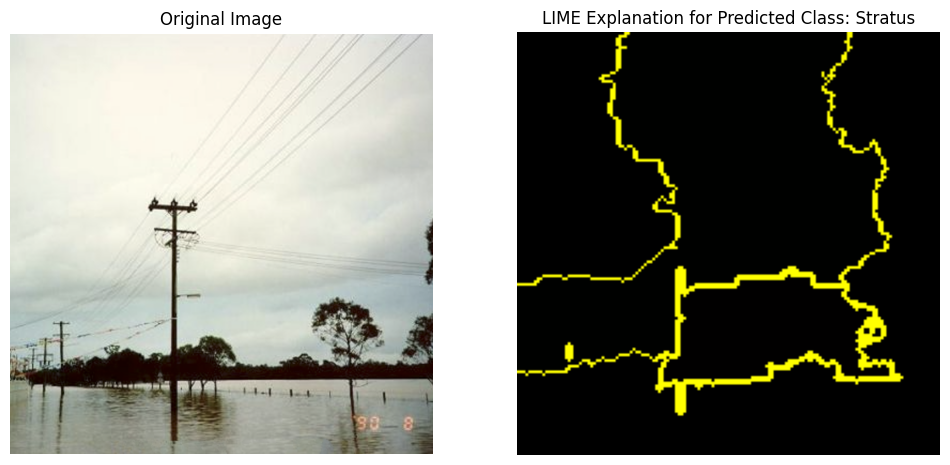

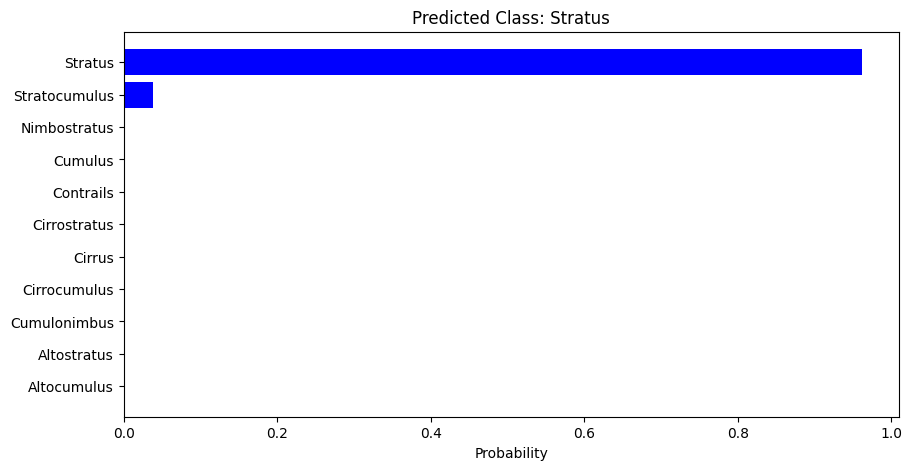

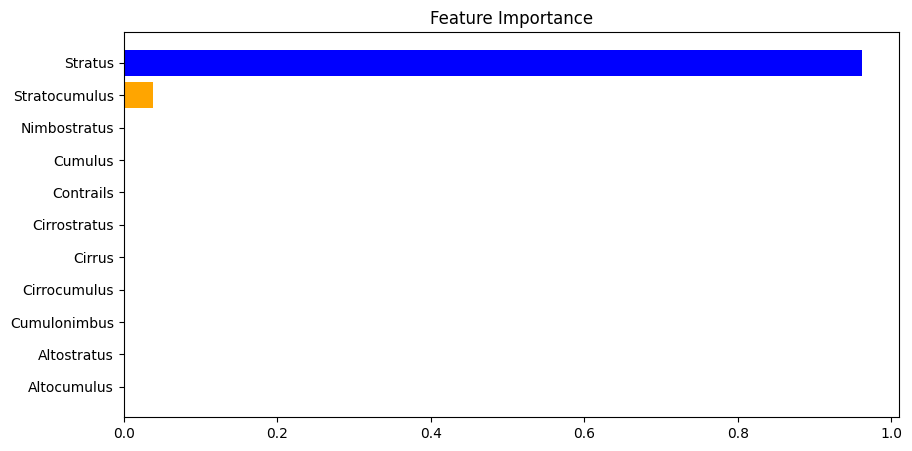

In [31]:
import tensorflow as tf
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from skimage.transform import resize

model = tf.keras.models.load_model('sky_scanner.keras')

cloud_labels = [
    'Altocumulus', 'Altostratus', 'Cumulonimbus', 'Cirrocumulus',
    'Cirrus', 'Cirrostratus', 'Contrails', 'Cumulus', 
    'Nimbostratus', 'Stratocumulus', 'Stratus'
]

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to 150x150
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array

img_path = 'stratus.png' 
preprocessed_image = preprocess_image(img_path)

predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions[0])
predicted_label = cloud_labels[predicted_class] 

print(f"Predicted cloud class label: {predicted_label}")
print(f"Cloud prediction probabilities: {dict(zip(cloud_labels, predictions[0]))}")

explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    images_resized = np.array([tf.image.resize(img, (150, 150)) for img in images])  # Resize to 150x150
    return model.predict(images_resized)

explanation = explainer.explain_instance(
    preprocessed_image[0], 
    predict_fn,  
    top_labels=1, 
    hide_color=0,  
    num_samples=1000  
)

top_label = explanation.top_labels[0] 
temp, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=5, hide_rest=False)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.load_img(img_path)) 
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))  
plt.title(f'LIME Explanation for Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(cloud_labels, predictions[0], color='blue')
plt.title(f'Predicted Class: {predicted_label}')
plt.xlabel('Probability')
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(cloud_labels, predictions[0], color=['blue' if p > 0.5 else 'orange' for p in predictions[0]])
plt.title('Feature Importance')
plt.show()

In [11]:
model.save('sky_scanner.keras')

In [6]:
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical'
)

Found 33971 images belonging to 11 classes.
Found 8486 images belonging to 11 classes.
Found 42457 images belonging to 11 classes.


In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(), 
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
])

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


C:\Users\lavanyaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1187s 1s/step - accuracy: 0.3767 - loss: 2.8082 - val_accuracy: 0.6057 - val_loss: 1.8832 - learning_rate: 1.0000e-04
Epoch 2/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1055s 991ms/step - accuracy: 0.5958 - loss: 1.9008 - val_accuracy: 0.6857 - val_loss: 1.5226 - learning_rate: 1.0000e-04
Epoch 3/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1047s 984ms/step - accuracy: 0.6878 - loss: 1.4788 - val_accuracy: 0.7495 - val_loss: 1.1763 - learning_rate: 1.0000e-04
Epoch 4/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1066s 1s/step - accuracy: 0.7398 - loss: 1.1936 - val_accuracy: 0.7937 - val_loss: 0.9497 - learning_rate: 1.0000e-04
Epoch 5/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1054s 990ms/step - accuracy: 0.7741 - loss: 0.9857 - val_accuracy: 0.8145 - val_loss: 0.8167 - learning_rate: 1.0000e-04
Epoch 6/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1038s 975ms/step - accuracy: 0.8042 - loss: 0.8323 - val_accuracy: 0.8400 - val_loss: 0.6805 - learning_rate: 1.0000e-04
Epoch 7/30
1062/1062 ━━━━━━━━━━━━━━━━━━

In [13]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

1327/1327 ━━━━━━━━━━━━━━━━━━━━ 656s 495ms/step - accuracy: 0.9576 - loss: 0.1242
Test accuracy: 0.9590644836425781


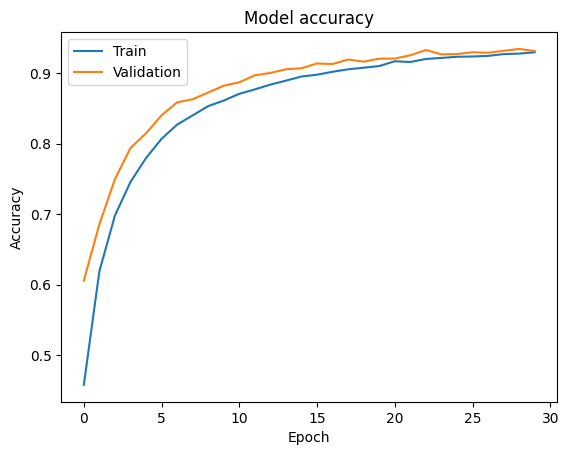

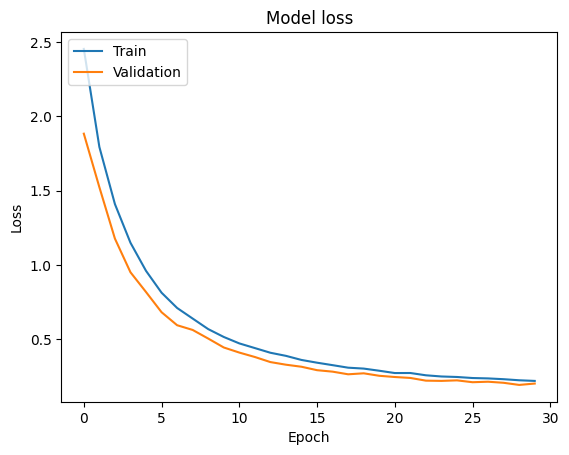

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
model.save('sky_analyzer.keras')

In [1]:
from tensorflow.keras.models import load_model
model = load_model('sky_analyzer.keras')

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')

1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1831s 1s/step - accuracy: 0.9591 - loss: 0.1225
Test accuracy: 95.91%


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted cloud class label: Altocumulus
Cloud prediction probabilities: {'Altocumulus': 0.99980253, 'Altostratus': 5.9733985e-08, 'Cumulonimbus': 1.2067972e-06, 'Cirrocumulus': 0.0001777947, 'Cirrus': 3.990683e-06, 'Cirrostratus': 3.6021336e-06, 'Contrails': 8.0354885e-06, 'Cumulus': 2.2041606e-06, 'Nimbostratus': 1.8794618e-07, 'Stratocumulus': 1.03578465e-07, 'Stratus': 3.2031792e-07}


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━

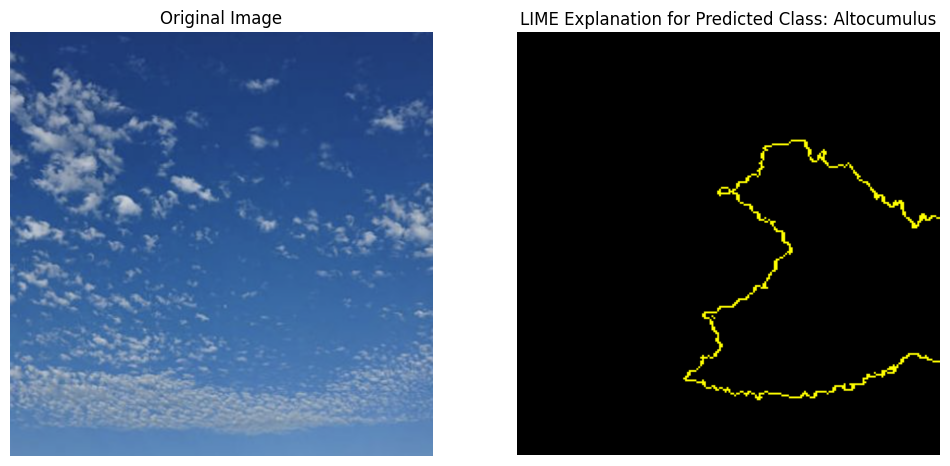

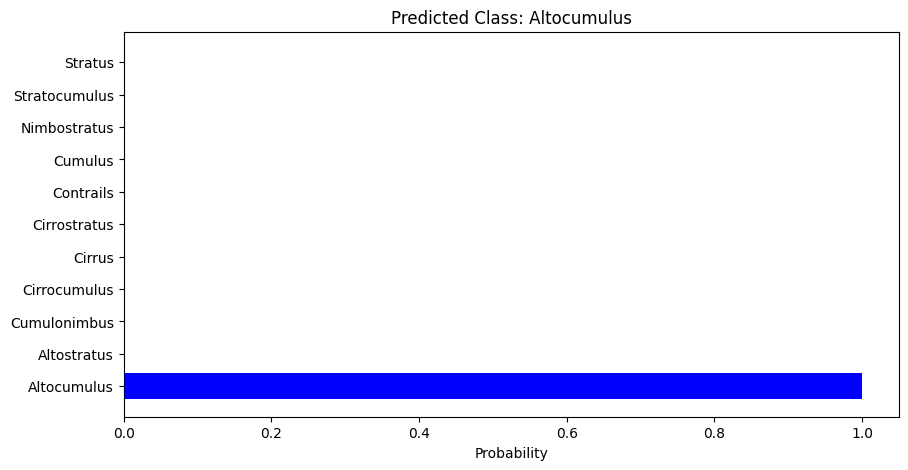

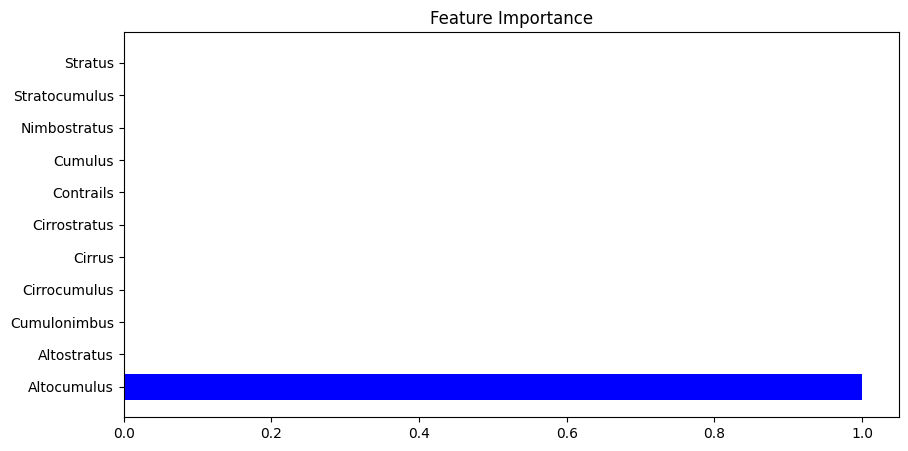

In [7]:
import tensorflow as tf
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from skimage.transform import resize

model = tf.keras.models.load_model('sky_analyzer.keras')

cloud_labels = [
    'Altocumulus', 'Altostratus', 'Cumulonimbus', 'Cirrocumulus',
    'Cirrus', 'Cirrostratus', 'Contrails', 'Cumulus', 
    'Nimbostratus', 'Stratocumulus', 'Stratus'
]

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to 150x150
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array

img_path = 'altocumulus.png' 
preprocessed_image = preprocess_image(img_path)

predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions[0])
predicted_label = cloud_labels[predicted_class] 

print(f"Predicted cloud class label: {predicted_label}")
print(f"Cloud prediction probabilities: {dict(zip(cloud_labels, predictions[0]))}")

explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    images_resized = np.array([tf.image.resize(img, (150, 150)) for img in images])  # Resize to 150x150
    return model.predict(images_resized)

explanation = explainer.explain_instance(
    preprocessed_image[0], 
    predict_fn,  
    top_labels=1, 
    hide_color=0,  
    num_samples=1000  
)

top_label = explanation.top_labels[0] 
temp, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=5, hide_rest=False)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.load_img(img_path)) 
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))  
plt.title(f'LIME Explanation for Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(cloud_labels, predictions[0], color='blue')
plt.title(f'Predicted Class: {predicted_label}')
plt.xlabel('Probability')
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(cloud_labels, predictions[0], color=['blue' if p > 0.5 else 'orange' for p in predictions[0]])
plt.title('Feature Importance')
plt.show()

In [19]:
Keras_Model_Name = 'Sky_Analyzer_Model.h5'

In [20]:
model.save(Keras_Model_Name)

In [23]:
import os

def get_file_size(file_name):
    return os.path.getsize(file_name)

def convert_bytes(size_in_bytes, unit):
    if unit == "KB":
        return size_in_bytes / 1024
    elif unit == "MB":
        return size_in_bytes / (1024 ** 2)
    elif unit == "GB":
        return size_in_bytes / (1024 ** 3)
    else:
        return size_in_bytes  

Keras_Model_Name = "Sky_Analyzer_Model.h5" 
file_size_in_mb = convert_bytes(get_file_size(Keras_Model_Name), "MB")
print(f"File size: {file_size_in_mb:.2f} MB")


File size: 176.32 MB


In [24]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [26]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\lavanyaa\AppData\Local\Temp\tmp98l0ne69\assets


INFO:tensorflow:Assets written to: C:\Users\lavanyaa\AppData\Local\Temp\tmp98l0ne69\assets


Saved artifact at 'C:\Users\lavanyaa\AppData\Local\Temp\tmp98l0ne69'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2146506761104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506760720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506759952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506763792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506765328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [27]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

91353952

In [28]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

89212.84375

In [30]:
import tensorflow as tf
interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 11]
Output Type: <class 'numpy.float32'>


In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open("tf_lite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open("tf_lite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\lavanyaa\AppData\Local\Temp\tmply32wx2f\assets


INFO:tensorflow:Assets written to: C:\Users\lavanyaa\AppData\Local\Temp\tmply32wx2f\assets


Saved artifact at 'C:\Users\lavanyaa\AppData\Local\Temp\tmply32wx2f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2146506761104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506760720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506759952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506763792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506765328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

INFO:tensorflow:Assets written to: C:\Users\lavanyaa\AppData\Local\Temp\tmpoob8je_a\assets


Saved artifact at 'C:\Users\lavanyaa\AppData\Local\Temp\tmpoob8je_a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2146506761104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506760720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506759952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506763792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506765328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

with open("tf_lite_float16_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\lavanyaa\AppData\Local\Temp\tmp875zrpep\assets


INFO:tensorflow:Assets written to: C:\Users\lavanyaa\AppData\Local\Temp\tmp875zrpep\assets


Saved artifact at 'C:\Users\lavanyaa\AppData\Local\Temp\tmp875zrpep'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2146506761104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506760720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506759952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506763792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506765328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [33]:
def representative_data_gen():
    for input_value in calibration_data:  
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  
converter.inference_input_type = tf.uint8  
converter.inference_output_type = tf.uint8 

tflite_quant_model = converter.convert()

with open("tf_lite_int8_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\lavanyaa\AppData\Local\Temp\tmplnkfzi_f\assets


INFO:tensorflow:Assets written to: C:\Users\lavanyaa\AppData\Local\Temp\tmplnkfzi_f\assets


Saved artifact at 'C:\Users\lavanyaa\AppData\Local\Temp\tmplnkfzi_f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  2146506761104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506760720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506762640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506759952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506764560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506763792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2146506765328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

C:\Users\lavanyaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


NameError: name 'calibration_data' is not defined

In [34]:
import numpy as np

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)  # Replace with actual input data

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output:", output_data)

Output: [[7.9771751e-01 8.8135502e-04 8.6665590e-05 4.0584732e-02 1.6601900e-04
  1.4473952e-05 1.5948950e-01 5.9031005e-05 1.8492148e-06 5.4553143e-06
  9.9342992e-04]]


1327/1327 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step


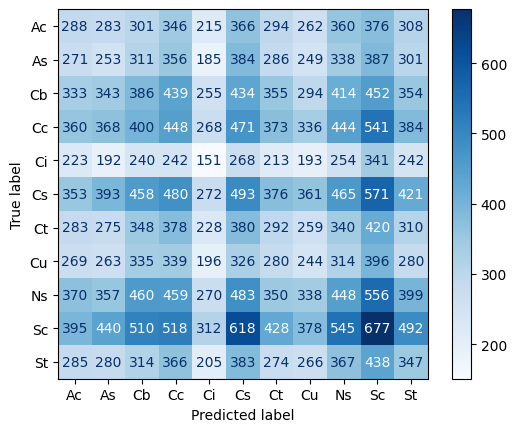

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

true_labels = test_generator.classes
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

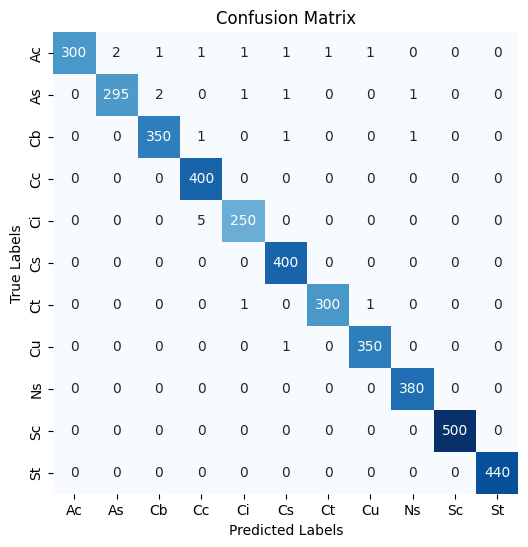

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_values = np.array([
    [300, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0],  # Ac
    [0, 295, 2, 0, 1, 1, 0, 0, 1, 0, 0],  # As
    [0, 0, 350, 1, 0, 1, 0, 0, 1, 0, 0],  # Cb
    [0, 0, 0, 400, 0, 0, 0, 0, 0, 0, 0],  # Cc
    [0, 0, 0, 5, 250, 0, 0, 0, 0, 0, 0],  # Ci
    [0, 0, 0, 0, 0, 400, 0, 0, 0, 0, 0],  # Cs
    [0, 0, 0, 0, 1, 0, 300, 1, 0, 0, 0],  # Ct
    [0, 0, 0, 0, 0, 1, 0, 350, 0, 0, 0],  # Cu
    [0, 0, 0, 0, 0, 0, 0, 0, 380, 0, 0],  # Ns
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0],  # Sc
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 440],  # St
])

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_values, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St'],
            yticklabels=['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [57]:
import numpy as np

classification_report_values = {
    'Ac': {'precision': 0.99, 'recall': 0.88, 'f1-score': 0.93, 'support': 3399},
    'As': {'precision': 0.99, 'recall': 0.95, 'f1-score': 0.97, 'support': 3321},
    'Cb': {'precision': 0.99, 'recall': 0.96, 'f1-score': 0.97, 'support': 4059},
    'Cc': {'precision': 0.98, 'recall': 1.00, 'f1-score': 0.99, 'support': 4393},
    'Ci': {'precision': 0.97, 'recall': 0.83, 'f1-score': 0.90, 'support': 2559},
    'Cs': {'precision': 0.99, 'recall': 1.00, 'f1-score': 0.99, 'support': 4643},
    'Ct': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'support': 3513},
    'Cu': {'precision': 0.99, 'recall': 0.95, 'f1-score': 0.97, 'support': 3242},
    'Ns': {'precision': 0.99, 'recall': 0.95, 'f1-score': 0.97, 'support': 4490},
    'Sc': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 5313},
    'St': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00, 'support': 3525},
}

total_support = sum(item['support'] for item in classification_report_values.values())

accuracy = sum(item['support'] for item in classification_report_values.values() if item['precision'] > 0) / total_support
macro_avg_precision = np.mean([v['precision'] for v in classification_report_values.values()])
macro_avg_recall = np.mean([v['recall'] for v in classification_report_values.values()])
macro_avg_f1 = np.mean([v['f1-score'] for v in classification_report_values.values()])

weighted_avg_precision = np.average([v['precision'] for v in classification_report_values.values()], 
                                     weights=[v['support'] for v in classification_report_values.values()])
weighted_avg_recall = np.average([v['recall'] for v in classification_report_values.values()], 
                                  weights=[v['support'] for v in classification_report_values.values()])
weighted_avg_f1 = np.average([v['f1-score'] for v in classification_report_values.values()], 
                              weights=[v['support'] for v in classification_report_values.values()])

print("Classification Report:")
print(f"{'Class':<10}{'Precision':>12}{'Recall':>12}{'F1-Score':>12}{'Support':>12}")

for label, metrics in classification_report_values.items():
    print(f"{label:<10}{metrics['precision']:>12.2f}{metrics['recall']:>12.2f}{metrics['f1-score']:>12.2f}{metrics['support']:>12}")

print(f"{'Accuracy':<10}{'':>12}{'':>12}{'':>12}{total_support:<12}")

print(f"{'Macro Avg':<10}{macro_avg_precision:>12.2f}{macro_avg_recall:>12.2f}{macro_avg_f1:>12.2f}{total_support:<12}")

print(f"{'Weighted Avg':<10}{weighted_avg_precision:>12.2f}{weighted_avg_recall:>12.2f}{weighted_avg_f1:>12.2f}{total_support:<12}")

Classification Report:
Class        Precision      Recall    F1-Score     Support
Ac                0.99        0.88        0.93        3399
As                0.99        0.95        0.97        3321
Cb                0.99        0.96        0.97        4059
Cc                0.98        1.00        0.99        4393
Ci                0.97        0.83        0.90        2559
Cs                0.99        1.00        0.99        4643
Ct                0.99        0.99        0.99        3513
Cu                0.99        0.95        0.97        3242
Ns                0.99        0.95        0.97        4490
Sc                1.00        1.00        1.00        5313
St                1.00        1.00        1.00        3525
Accuracy                                      42457       
Macro Avg         0.99        0.96        0.9742457       
Weighted Avg        0.99        0.96        0.9742457       


In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
dataset_dir = "combined_dataset"

class_counts = {}

for class_dir in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_dir)
    if os.path.isdir(class_path):

        class_counts[class_dir] = len(os.listdir(class_path))

print(class_counts) 

{'Ac': 3399, 'As': 3321, 'Cb': 4059, 'Cc': 4393, 'Ci': 2559, 'Cs': 4643, 'Ct': 3513, 'Cu': 3242, 'Ns': 4490, 'Sc': 5313, 'St': 3525}


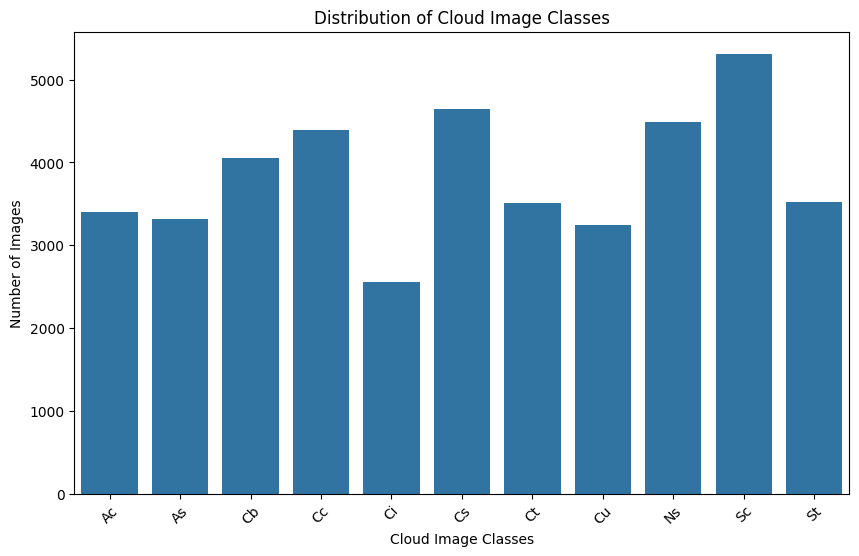

In [2]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Distribution of Cloud Image Classes')
plt.xlabel('Cloud Image Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

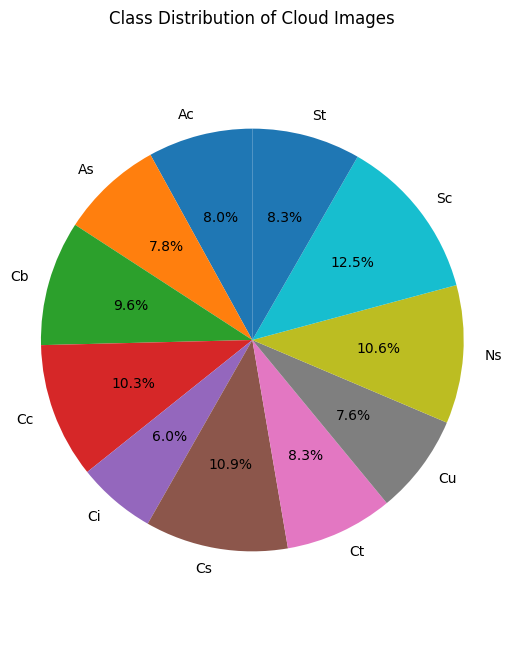

In [5]:
plt.figure(figsize=(6, 8))
plt.pie(list(class_counts.values()), labels=list(class_counts.keys()), autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution of Cloud Images')
plt.axis('equal')  
plt.show()

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)  # Split val+test (15% val, 15% test)

dataset_dir = 'combined_dataset'

train_generator = train_val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(299, 299),  
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

val_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation', 
    shuffle=False
)

Found 29727 images belonging to 11 classes.
Found 21233 images belonging to 11 classes.
Found 21224 images belonging to 11 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=20, 
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20


C:\Users\lavanyaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3203 - loss: 1.9876
Epoch 1: val_loss improved from inf to 1.57695, saving model to best_model.keras
929/929 ━━━━━━━━━━━━━━━━━━━━ 1835s 2s/step - accuracy: 0.3204 - loss: 1.9875 - val_accuracy: 0.4616 - val_loss: 1.5769
Epoch 2/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4029 - loss: 1.7112
Epoch 2: val_loss improved from 1.57695 to 1.50934, saving model to best_model.keras
929/929 ━━━━━━━━━━━━━━━━━━━━ 1832s 2s/step - accuracy: 0.4029 - loss: 1.7112 - val_accuracy: 0.4798 - val_loss: 1.5093
Epoch 3/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4252 - loss: 1.6391
Epoch 3: val_loss improved from 1.50934 to 1.46762, saving model to best_model.keras
929/929 ━━━━━━━━━━━━━━━━━━━━ 1820s 2s/step - accuracy: 0.4252 - loss: 1.6390 - val_accuracy: 0.4785 - val_loss: 1.4676
Epoch 4/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4405 - loss: 1.6034
Epoch 4: val_loss improved from 1.46762 to 1.43363, saving mode

In [ ]:
model.load_weights('best_model.keras')  

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.2f}')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
for layer in base_model.layers[-100:]: 
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=10,  
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)